## Compare the number of road collisions in Dublin to other counties in the Republic of Ireland
### A data science approach to investigation into road accidents using data from [RSA](https://data.gov.ie/dataset/roa27-traffic-collisions-and-casualities?package_type=dataset)
#### Naomi Tunstead - sba22222
#### MSc in Data Analytics
#### MSC_DA_CA1

In [1]:
# Read in libraries needed for analysis
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from MissForestExtra import MissForestExtra

In [2]:
# Import the data
df = pd.read_csv('traffic_collisions_and_casualties_county.csv')

In [3]:
# High level overview of the dataset
df.sample(10)

,Statistic,Year,County,UNIT,VALUE
128,Injury Collisions,2013,Leitrim,Number,32
49,Fatal Collisions,2014,Roscommon,Number,6
28,Fatal Collisions,2014,Carlow,Number,5
441,Injured Casualites,2013,Offaly,Number,135
249,All Fatal and Injury Collisions,2014,Longford,Number,63
168,Injury Collisions,2016,Longford,Number,67
104,Fatal Collisions,2017,Sligo,Number,2
313,All Fatal and Injury Collisions,2017,Limerick,Number,266
160,Injury Collisions,2014,Donegal,Number,200
211,Injury Collisions,2017,Roscommon,Number,85


In [4]:
# Check the datatypes for each column and determine if they are correct or not
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 648 entries, 0 to 647
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Statistic  648 non-null    object
 1   Year       648 non-null    int64 
 2   County     648 non-null    object
 3   UNIT       648 non-null    object
 4   VALUE      648 non-null    int64 
dtypes: int64(2), object(3)
memory usage: 25.4+ KB


First thing to note about the data is that `UNIT` is something we can drop. `Statistic` is also something we could convert to long format to enable more graphics. `Year` is also counted as an int when it should be a categorical. Also we can see that there are totals embedded in the dataset that should be dropped.

In [5]:
# Drop the unit column
df = df.drop('UNIT', axis = 1)

In [6]:
# Changing the year column to an object
df['Year'] = df['Year'].astype('category')

In [7]:
# Remove the total columns so summary statistics are not wrong
df = df[df['Statistic'].isin(['Injured Casualites', 'Fatal Collisions', 'Injury Collisions', 'Killed Casualities'])]

In [8]:
# Looking at the value column
df.describe()

,VALUE
count,432.000000
mean,249.421296
std,922.224393
min,0.000000
25%,5.000000
50%,55.500000
75%,168.250000
max,8079.000000


The maximum value is extremely large lets check this to be sure its valid.

In [9]:
df[df['VALUE'] == 8079]

,Statistic,Year,County,VALUE
459,Injured Casualites,2014,All Counties,8079


We have a county called 'All Counties' that we have to remove , similar to the `Statistic` column

In [10]:
# Remove the total columns so summary statistics are more accurate
df = df[~df['County'].isin(['All Counties'])]

Let's check the summary statistics again

In [11]:
df.describe()

,VALUE
count,416.000000
mean,129.507212
std,275.958343
min,0.000000
25%,5.000000
50%,30.500000
75%,159.500000
max,2258.000000


In [12]:
#Poisson Distribution 
#What is the probability of getting more than the mean number of collisions? 
import statistics as stats
from scipy.stats import poisson
poisson.sf(k = 130, mu = 129.507212)

0.4594705344127065

In [13]:
#Normal Distribution 
#What is the probability of getting more than the mean number of collisions? 
from scipy.stats import norm
def z_score(n,mean):
    return ((n+0.5)-mean)/np.sqrt(mean)

norm.sf(z_score(130, 129.507212))

0.46524086073842486

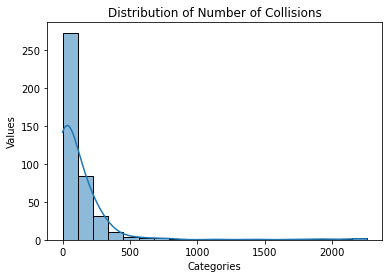

In [14]:
sns.histplot(data = df, x = 'VALUE', bins = 20, kde = True)
plt.title('Distribution of Number of Collisions')
plt.xlabel('Categories')
plt.ylabel('Values');

We can see from the distribution that the data is very right skewed, where the mean is larger than the modal value

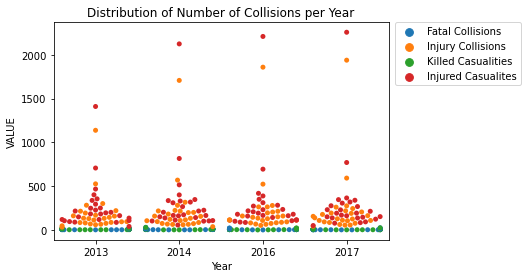

In [15]:
plt.title('Distribution of Number of Collisions per Year')
sns.swarmplot(data = df, x=df['Year'], y=df['VALUE'], hue = 'Statistic')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0);

We can see there are some outliers for injuries that would be worth looking into where they are occuring. Since there are only a few going up each year I would assume Dublin due to population

In [16]:
df[df['VALUE'] > 1000]

,Statistic,Year,County,VALUE
110,Injury Collisions,2013,Dublin,1138
137,Injury Collisions,2014,Dublin,1708
164,Injury Collisions,2016,Dublin,1859
191,Injury Collisions,2017,Dublin,1939
434,Injured Casualites,2013,Dublin,1410
461,Injured Casualites,2014,Dublin,2125
488,Injured Casualites,2016,Dublin,2210
515,Injured Casualites,2017,Dublin,2258


**Insight: We can see the number of injuries in Dublin are far larger than the rest of ROI.**

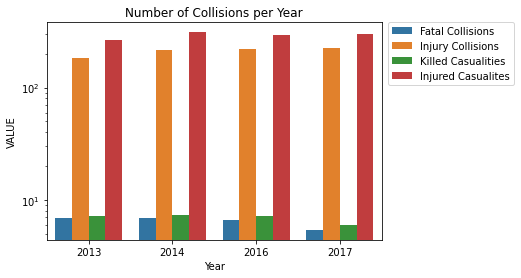

In [17]:
g = sns.barplot(data=df, x='Year', y=(df.VALUE), hue = 'Statistic',ci = None)
plt.title('Number of Collisions per Year')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
g.set_yscale('log')

**Insight: We can see there is no data for 2015 at all**

In [18]:
#Casualties is spelled wrong. Need to fix
df = df.replace('Killed Casualities', 'Killed Casualties')
df = df.replace('Injured Casualites', 'Injured Casualties')

In [19]:
# Rename value column for cleanliness.
df.rename({'VALUE': 'Value'}, axis=1, inplace=True)

In [20]:
# Show all permutations of Statistic with County, pull back some columns using describe, reset index to remove grouping and pick only first 2 cols
df_2015_impute_base = df.groupby(['Statistic','County'])[['Statistic', 'County']].describe().reset_index().iloc[:, 0:2]
# Make 2 new columns with constant values 
df_2015_impute_base['Year'] = 2015
df_2015_impute_base['Value'] = None
# Move columns to match original dataframe so append works without error.
df_2015_impute_base = df_2015_impute_base[['Statistic', 'Year', 'County', 'Value']]
# Column names were not the same upon first try to concatenate. This removes that error.
df_2015_impute_base.columns = df.columns
# View the result
df_2015_impute_base.sample(10)

,Statistic,Year,County,Value
61,Injury Collisions,2015,Kilkenny,None
99,Killed Casualties,2015,Tipperary,None
65,Injury Collisions,2015,Longford,None
56,Injury Collisions,2015,Donegal,None
52,Injury Collisions,2015,Carlow,None
60,Injury Collisions,2015,Kildare,None
42,Injured Casualties,2015,Meath,None
69,Injury Collisions,2015,Monaghan,None
90,Killed Casualties,2015,Limerick,None
3,Fatal Collisions,2015,Cork,None


In [21]:
len(df_2015_impute_base.index)

104

In [22]:
mod_df = pd.concat([df, df_2015_impute_base], ignore_index=True)
print('Modified Dataframe')
mod_df.sample(10)

Modified Dataframe


,Statistic,Year,County,Value
247,Killed Casualties,2014,Cork,19
183,Injury Collisions,2017,Dublin,1939
30,Fatal Collisions,2014,Laois,6
348,Injured Casualties,2014,Wexford,225
446,Injured Casualties,2015,Donegal,None
333,Injured Casualties,2013,Roscommon,119
409,Injured Casualties,2017,Leitrim,50
246,Killed Casualties,2014,Clare,5
28,Fatal Collisions,2014,Kildare,3
170,Injury Collisions,2016,Kerry,195


In [23]:
mod_df = mod_df.sort_values(by=['Statistic','Year'])

## MissForest

In [24]:
mfe = MissForestExtra()
df_imputed = mfe.impute(mod_df, RandomForestClassifier(), RandomForestRegressor())

In [25]:
df_imputed[df_imputed['Year'] == 2015]

,Statistic,Year,County,Value
416,Fatal Collisions,2015,Carlow,7.53
417,Fatal Collisions,2015,Cavan,1.54
418,Fatal Collisions,2015,Clare,4.05
419,Fatal Collisions,2015,Cork,18.16
420,Fatal Collisions,2015,Donegal,8.0
...,...,...,...,...
515,Killed Casualties,2015,Tipperary,13.03
516,Killed Casualties,2015,Waterford,6.2
517,Killed Casualties,2015,Westmeath,5.07
518,Killed Casualties,2015,Wexford,4.72


In [26]:
# This method rounds down from say 1.9 to 1. This is good as it gives actual amounts rather than points being rounded up and over count.
df_imputed['Value'] = df_imputed['Value'].astype('int')

In [27]:
df_imputed[df_imputed['Year'] == 2015]

,Statistic,Year,County,Value
416,Fatal Collisions,2015,Carlow,7
417,Fatal Collisions,2015,Cavan,1
418,Fatal Collisions,2015,Clare,4
419,Fatal Collisions,2015,Cork,18
420,Fatal Collisions,2015,Donegal,8
...,...,...,...,...
515,Killed Casualties,2015,Tipperary,13
516,Killed Casualties,2015,Waterford,6
517,Killed Casualties,2015,Westmeath,5
518,Killed Casualties,2015,Wexford,4


In [28]:
df_imputed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 520 entries, 0 to 311
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Statistic  520 non-null    object
 1   Year       520 non-null    int64 
 2   County     520 non-null    object
 3   Value      520 non-null    int32 
dtypes: int32(1), int64(1), object(2)
memory usage: 18.3+ KB


In [29]:
df_imputed['Statistic'] = df_imputed['Statistic'].astype('category')
df_imputed['County'] = df_imputed['County'].astype('category')

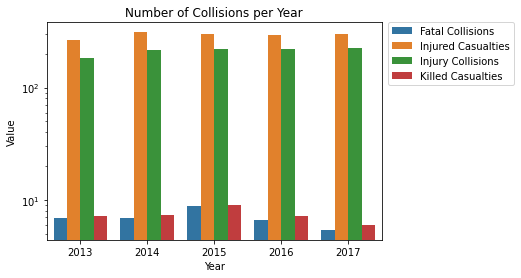

In [30]:
g = sns.barplot(data=df_imputed, x='Year', y=(df_imputed['Value']), hue = 'Statistic',ci = None)
plt.title('Number of Collisions per Year')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
g.set_yscale('log')

Fatal collisions and killed casualities are more inflated in 2015 than other years. This may be down to rounding the imputed data. Therefore we need to test how accurate it is to use MissForest on our data.

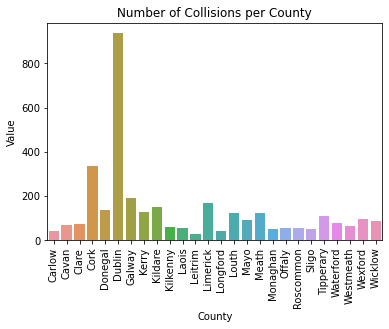

In [31]:
sns.barplot(data=df_imputed, x='County', y=(df_imputed.Value), ci = None)
plt.title('Number of Collisions per County')
plt.xticks(rotation=90);

In order to ensure that everything went smoothly, I want to be able to analyze the MissForest method.

To accomplish this, I can simply turn some of the columns in my original dataset to null, run the algorithm on this data, and then resolve the artificially made nulls to see how it performs in comparison to those columns.

In [32]:
def stratified_sample_df(df, col, n_samples):
    n = min(n_samples, df[col].value_counts().min())
    df_ = df.groupby(col).apply(lambda x: x.sample(n))
    df_.index = df_.index.droplevel(0)
    return df_

In [33]:
import pandas as pd
df = pd.read_csv('traffic_collisions_and_casualties_county.csv')

In [34]:
df_sample = df[~df.isnull().any(axis=1)]

df_sample = stratified_sample_df(df_sample, 'Year', 10)

df_sample_copy = df_sample.copy()

In [35]:
df_sample

,Statistic,Year,County,UNIT,VALUE
224,All Fatal and Injury Collisions,2013,Meath,Number,167
335,Killed Casualities,2013,Wexford,Number,7
21,Fatal Collisions,2013,Mayo,Number,6
11,Fatal Collisions,2013,Wexford,Number,7
19,Fatal Collisions,2013,Galway,Number,13
438,Injured Casualites,2013,Longford,Number,86
327,Killed Casualities,2013,Kildare,Number,15
108,Injury Collisions,2013,All Counties,Number,4797
457,Injured Casualites,2013,Donegal,Number,355
450,Injured Casualites,2013,Waterford,Number,195


In [36]:
import random
r4 = random.sample(range(len(df_sample)),12)
df_sample['VALUE'] = [val if i not in r4 else np.nan for i, val in enumerate(df_sample['VALUE'])]

In [37]:
df_sample

,Statistic,Year,County,UNIT,VALUE
224,All Fatal and Injury Collisions,2013,Meath,Number,NaN
335,Killed Casualities,2013,Wexford,Number,NaN
21,Fatal Collisions,2013,Mayo,Number,6.0
11,Fatal Collisions,2013,Wexford,Number,NaN
19,Fatal Collisions,2013,Galway,Number,13.0
438,Injured Casualites,2013,Longford,Number,86.0
327,Killed Casualities,2013,Kildare,Number,NaN
108,Injury Collisions,2013,All Counties,Number,NaN
457,Injured Casualites,2013,Donegal,Number,355.0
450,Injured Casualites,2013,Waterford,Number,195.0


In [38]:
mfe = MissForestExtra()
imputed = mfe.impute(df_sample, RandomForestClassifier(), RandomForestRegressor())

In [39]:
imputed['VALUE Original'] = df_sample_copy['VALUE']

imputed['Stdev'] = imputed['VALUE Original'].std()


# Define the error between the original and imputed values
imputed['abs_error'] = np.abs(imputed['VALUE Original'] - imputed['VALUE'])

# Define a score metric we can use to evaluate the model
imputed['Score'] = np.where(imputed.abs_error < imputed.Stdev, 1, 0)

In [40]:
imputed

,Statistic,Year,County,UNIT,VALUE,VALUE Original,Stdev,abs_error,Score
224,All Fatal and Injury Collisions,2013,Meath,Number,180.46,167,1494.4823,13.46,1
335,Killed Casualities,2013,Wexford,Number,130.50,7,1494.4823,123.50,1
21,Fatal Collisions,2013,Mayo,Number,6.00,6,1494.4823,0.00,1
11,Fatal Collisions,2013,Wexford,Number,18.79,7,1494.4823,11.79,1
19,Fatal Collisions,2013,Galway,Number,13.00,13,1494.4823,0.00,1
438,Injured Casualites,2013,Longford,Number,86.00,86,1494.4823,0.00,1
327,Killed Casualities,2013,Kildare,Number,316.73,15,1494.4823,301.73,1
108,Injury Collisions,2013,All Counties,Number,1118.44,4797,1494.4823,3678.56,0
457,Injured Casualites,2013,Donegal,Number,355.00,355,1494.4823,0.00,1
450,Injured Casualites,2013,Waterford,Number,195.00,195,1494.4823,0.00,1


In [41]:
df_sample.describe()

,Year,VALUE
count,40.000000,28.000000
mean,2015.000000,472.214286
std,1.601282,1570.935847
min,2013.000000,1.000000
25%,2013.750000,11.500000
50%,2015.000000,117.000000
75%,2016.250000,193.500000
max,2017.000000,8272.000000


In [42]:
score = 1 - (np.abs(imputed['Score'].sum() - imputed['Score'].count()) / imputed['Score'].sum())
print(round(score, 4))

0.9743589743589743

In [43]:
from sklearn.metrics import r2_score

r2 = r2_score(imputed['VALUE Original'], imputed['VALUE'])
print(round(r2, 4))

0.8319


In [44]:
from sklearn.metrics import  mean_squared_error

mse = np.sqrt(mean_squared_error(imputed['VALUE Original'], imputed['VALUE']))
print(round(mse,4))

605.0563


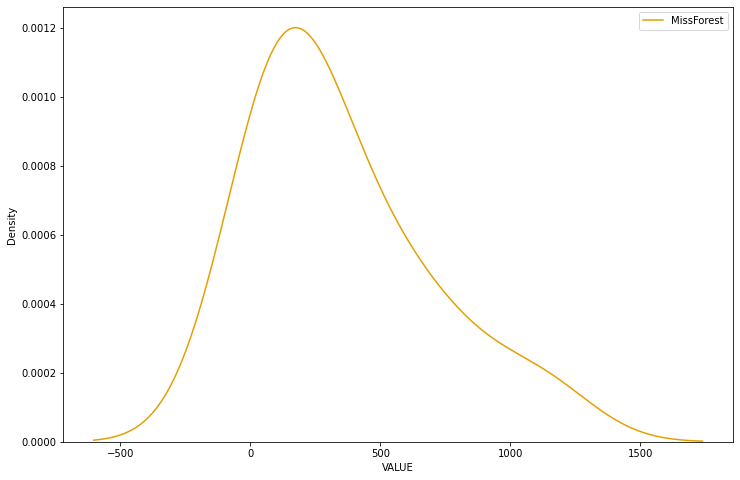

In [45]:
plt.figure(figsize=(12,8))
sns.kdeplot(x = df_sample['VALUE'][df_sample.isnull().any(axis=1)], label= 'Original', color='#009E73')
sns.kdeplot(x = imputed['VALUE'][df_sample.isnull().any(axis=1)], label = 'MissForest', color='#E69F00')
plt.legend()

Missing Forest was determined to be the good method for usage across the full dataset because it provided an $R^2$ score for the data 0.8319. As well as the average score for each imputed value is 0.9744 and MSE is 605.0563.

## Decision Tree

In [78]:
df_imputed_modelling = pd.get_dummies(df_imputed, columns=['Statistic', 'Year', 'County'])

In [79]:
# Create the independent and dependent variables
X = df_imputed_modelling.iloc[:, 1:]
y = df_imputed['Value']

In [80]:
X

,Statistic_Fatal Collisions,Statistic_Injured Casualties,Statistic_Injury Collisions,Statistic_Killed Casualties,Year_2013,Year_2014,Year_2015,Year_2016,Year_2017,County_Carlow,...,County_Meath,County_Monaghan,County_Offaly,County_Roscommon,County_Sligo,County_Tipperary,County_Waterford,County_Westmeath,County_Wexford,County_Wicklow
0,1,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,0,0,0,1,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
308,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
309,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
310,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [81]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0) 

In [56]:
# Load the library 'sklearn.tree'
from sklearn.tree import DecisionTreeRegressor

# Create and initialise a DecisionTreeClassifier
regressor = DecisionTreeRegressor(max_depth = 4, random_state = 0)

### GridSearchCV

The Cross-Validation method is used by GridSearchCV to evaluate the model for every combination of the variables supplied in the dictionary. As a result, after employing this function, we can determine the accuracy and loss for each set of hyperparameters and select the combination that offers the best performance.

In [57]:
param_grid = {'max_depth' : [17, 18, 19, 20, 21, 22, 23]}

In [58]:
from sklearn.model_selection import GridSearchCV
CV_rfc = GridSearchCV(estimator=regressor, param_grid=param_grid,return_train_score=True, scoring='r2', cv= 10)
CV_rfc.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=DecisionTreeRegressor(max_depth=4, random_state=0),
             param_grid={'max_depth': [17, 18, 19, 20, 21, 22, 23]},
             return_train_score=True, scoring='r2')

In [59]:
print(CV_rfc.best_params_)
print(CV_rfc.best_score_)

{'max_depth': 23}
0.9536657567378082


In [82]:
# Load the library 'sklearn.tree'
from sklearn.tree import DecisionTreeRegressor

# Create and initialise a DecisionTreeClassifier
regressor = DecisionTreeRegressor(max_depth = 23, random_state = 0)

# Train the classifier by calling a method 'fit()'
regressor.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=23, random_state=0)

In [84]:
# Calculate the predicted value by calling a method predict()
y_pred = regressor.predict(X_test)

In [85]:
from sklearn import metrics
mae = metrics.mean_absolute_error(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = metrics.r2_score(y_test, y_pred)

In [86]:
print(f'R2 Score: {round(r2,4)}')
print(f'MAE Score: {round(mae,4)}')
print(f'MSE Score: {round(mse,4)}')
print(f'RMSE Score: {round(rmse,4)}')

R2 Score: 0.9942
MAE Score: 12.6817
MSE Score: 554.7474
RMSE Score: 23.5531


I have left the below commented out because it won't run for me but I want to show that I know this is apart of my Machine Learning. This would have shown me the results of my Decision Tree. I know it is not working because my y_pred is a numpy.ndarray and my y_test is a pandas.core.series.Series. No matter how I try to convert them to be the same it still won't work. 

In [ ]:
# #Import scikit-learn metrics module for accuracy calculation
# from sklearn import metrics
# # Model Accuracy, how often is the classifier correct?
# print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

In [ ]:
# from sklearn.metrics import classification_report, confusion_matrix
# import seaborn as sns

# # Calculate cm by calling a method named as 'confusion_matrix'
# cm = confusion_matrix(y_test, y_pred)

# # Call a method heatmap() to plot confusion matrix
# sns.heatmap(cm, annot = True)

# # print the classification_report based on y_test and y_predict
# print(classification_report(y_test, y_pred))

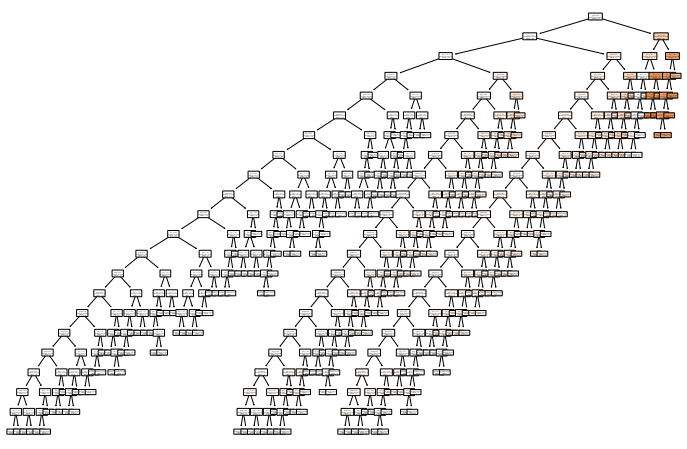

In [65]:
import matplotlib.pyplot as plt
from sklearn import tree

# Set the size of the figure
plt.figure(figsize = (12, 8))

# Display the tree by calling a method plot_tree()
tree.plot_tree(regressor.fit(X_train, y_train),filled=True, rounded=True, precision=2) ;

## Random Forest

In [89]:
df_imputed_modelling = pd.get_dummies(df_imputed, columns=['Statistic', 'Year', 'County'])

In [90]:
# Create the independent and dependent variables
X = df_imputed_modelling.iloc[:, 1:]
y = df_imputed['Value']

In [91]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0) 

In [92]:
# Load the library 'sklearn.tree'
from sklearn.ensemble import RandomForestRegressor

# Create and initialise a DecisionTreeClassifier
regressor = RandomForestRegressor(max_depth = 4, random_state = 0)

In [93]:
param_grid = {'n_estimators': [5, 10, 20, 30], 
              'max_depth' : [17, 18, 19, 20, 21, 22, 23]}

In [104]:
from sklearn.model_selection import GridSearchCV
cv_rfc = GridSearchCV(estimator=regressor, param_grid=param_grid,return_train_score=True, scoring='r2', cv= 10)
cv_rfc.fit(X_train, y_train)

In [ ]:
print(CV_rfc.best_params_)
print(CV_rfc.best_score_)

In [95]:
# Load the library 'sklearn.tree'
from sklearn.ensemble import RandomForestRegressor

# Create and initialise a DecisionTreeClassifier
regressor = RandomForestRegressor( n_estimators = 10, max_depth = 20, random_state = 0, n_jobs = -1)

# Train the classifier by calling a method 'fit()'
regressor.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=0)

In [96]:
# Calculate the predicted vlaue by calling a method predict()
y_pred = regressor.predict(X_test)

In [97]:
from sklearn import metrics
mae = metrics.mean_absolute_error(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = metrics.r2_score(y_test, y_pred)

In [98]:
metrics.r2_score(y_test, y_pred)

0.876350435726166

In [99]:
print(f'R2 Score: {r2}')
print(f'MAE Score: {mae}')
print(f'MSE Score: {mse}')
print(f'RMSE Score: {rmse}')

R2 Score: 0.876350435726166
MAE Score: 29.39982144436956
MSE Score: 11744.948966167472
RMSE Score: 108.37411575725761


I commented the below out as well for the same reason as the Decision Tree. 

In [102]:
# #Import scikit-learn metrics module for accuracy calculation
# from sklearn import metrics
# # Model Accuracy, how often is the classifier correct?
# print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

In [103]:
# from sklearn.metrics import classification_report, confusion_matrix
# import seaborn as sns

# # Calculate cm by calling a method named as 'confusion_matrix'
# cm = confusion_matrix(y_test, y_pred)

# # Call a method heatmap() to plot confusion matrix
# sns.heatmap(cm, annot = True)

# # print the classification_report based on y_test and y_predict
# print(classification_report(y_test, y_pred))

## Reference: 
1. <p>https://github.com/OisinB-2814/masters_thesis_ob2814/blob/master/notebooks/2-define.ipynb</p>